# Combined CCLE Model Training

This notebook combines the CCLE gene expression dataset with dynamic features and then is trained together

## Initialisation

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
core_used = 32
normalised = True
save_model = True
fixed_random_seed = 42  # -1 for no seed, NOT IN USE
save_figure = False
save_data = True
show_figure = False
rngs = list(range(100)) # for stable rng, for pure random, a random set can be used

In [4]:
# dynamic_data_code = 'fgfr4_ccle_dynamic_features_v2'
# drug_code = 'gdsc-1-FGFR_0939'
# match_rules_data_code = 'fgfr4_model_ccle_match_rules'
# folder_name = "FGFR4-combined-model-training"
# exp_id = "fgfr4_v4"  # experiment id, fgfr4_v1, cdk46_v1

In [5]:
dynamic_data_code = 'cdk46_ccle_dynamic_features_v3'
drug_code = 'gdsc-2-Palbociclib'
match_rules_data_code = 'cdk_model_match_rules'
folder_name = "CDK46-combined-model-training"
exp_id = "cdk46_v4" # experiment id, fgfr4_v1, cdk46_v1

In [6]:
# load in dynamic features data 
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_data_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = f'ccle-{drug_code}-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

match_rules = data_link.get_data_from_code(match_rules_data_code)

Data loaded for code generic-gdsc-2-Palbociclib-LN_IC50-cdk46_ccle_dynamic_features_v3-true-Unnamed: 0 Feature Shape (584, 590) Label Shape (584,)
Data loaded for code ccle-gdsc-2-Palbociclib-LN_IC50 Feature Shape (584, 19221) Label Shape (584,)


In [7]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [8]:
all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [9]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(584, 19221)
(584,)


In [10]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [11]:
combined_feature_data

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,CDK2ccCYCEccP27p_auc,CDK2ccCYCEccP27p_median,CDK2ccCYCEccP27p_tfc,CDK2ccCYCEccP27p_tmax,CDK2ccCYCEccP27p_max,CDK2ccCYCEccP27p_tmin,CDK2ccCYCEccP27p_min,CDK2ccCYCEccP27p_ttsv,CDK2ccCYCEccP27p_tsv,CDK2ccCYCEccP27p_init
SIDM00872,5.296090,0.000000,6.794416,3.452859,5.260778,0.042644,4.339137,5.833143,7.313246,4.764474,...,0.004366,0.004577,0.605010,0.967742,0.004583,0.0,0.002856,0.032258,0.002856,0.002856
SIDM00866,5.214125,0.000000,6.328047,3.168321,4.654206,0.042644,0.432959,6.574102,5.140779,5.114783,...,0.004215,0.004457,1.130657,0.967742,0.004466,0.0,0.002096,0.032258,0.002096,0.002096
SIDM00885,5.241840,0.201634,5.615299,3.090853,3.732269,0.084064,0.111031,4.026800,5.471513,6.019480,...,0.004297,0.004550,0.989570,0.967742,0.004551,0.0,0.002288,0.032258,0.002288,0.002288
SIDM00884,3.481557,0.000000,7.070389,2.341986,3.679199,0.176323,3.420887,5.854494,5.976134,5.112283,...,0.004537,0.004764,0.350453,0.967742,0.004774,0.0,0.003535,0.032258,0.003535,0.003535
SIDM00874,4.903038,0.000000,7.177719,2.744161,4.648465,0.150560,0.070389,5.819924,4.374344,3.814550,...,0.004449,0.004674,0.639426,0.967742,0.004685,0.0,0.002858,0.032258,0.002858,0.002858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00741,5.054848,0.000000,6.229588,2.805292,4.458776,0.189034,0.028569,0.650765,3.883621,5.510012,...,0.003852,0.004156,1.026422,0.967742,0.004186,0.0,0.002066,0.032258,0.002066,0.002066
SIDM00760,5.282810,0.000000,6.273516,3.090853,5.070389,0.310340,0.124328,2.950468,3.889474,5.275380,...,0.003763,0.004073,1.328825,0.967742,0.004097,0.0,0.001759,0.032258,0.001759,0.001759
SIDM00273,4.631104,0.000000,6.685940,2.739848,4.545968,0.028569,1.007196,6.046797,4.066950,4.890447,...,0.004359,0.004593,2.175721,0.967742,0.004600,0.0,0.001449,0.032258,0.001449,0.001449
SIDM00560,5.127221,0.000000,7.304146,1.782409,4.192983,0.137504,0.189034,6.446422,4.791814,3.723559,...,0.004616,0.004870,0.681136,0.967742,0.004884,0.0,0.002905,0.032258,0.002905,0.002905


In [12]:
def normalise_data(data): 
    data = (data - data.mean()) / data.std()
    return data

def pipeline_func(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first 
    # normalise X_train 
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}
    
def eval_func(X_test, y_test, pipeline_components=None, 
              normalised=False,
              save_model=False, 
              **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    returned_data = {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp}
    if save_model:
        returned_data['model'] = pipeline_components['model']
    return returned_data

def eval_func_best(X_test, y_test, pipeline_components=None, normalised=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

#### custom pipelines

In [13]:
def pipeline_select_genes_only(X_train, y_train, rng, model_used, keep_features, normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    dynamic_X_train = X_train[final_selected_features]
    static_X_train = X_train.drop(final_selected_features, axis=1)
    k = X_train.shape[1]
    if k > 500:
        k = 500  # limit the number of features to 500
    selected_features, scores = f_regression_select(static_X_train, y_train, k)
    for f in selected_features:
        final_selected_features.append(f)
    selected_X_train = X_train[final_selected_features]
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [14]:
def pipeline_select_only(X_train, y_train, rng, model_used, 
                                     keep_features, limit_features = False, 
                         normalised=False, **kwargs):
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    final_selected_features = keep_features
    selected_X_train = X_train[final_selected_features]
    # get the scores for the selected features using f_regression
    k = selected_X_train.shape[1]
    if limit_features:
        if k > 500:
            k = 500  # limit the number of features to 500
    _, scores = f_regression_select(selected_X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    model.fit(selected_X_train, y_train)
    return {'model': model,
            'filter_selected_features': final_selected_features,
            'filter_scores': scores}

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

def pipeline_func_ffs(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first
    # normalise X_train
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500:
        k = 500  # limit the number of features to 500
    model = get_model_from_string(model_used, **kwargs)
    sfs_forward = SequentialFeatureSelector(
        model, n_features_to_select=2, direction="forward"
    ).fit(X_train, y_train)
    selected_features, X_selected = select_preset_features(
        X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': None}

In [15]:
transformed_gene_list = [] 
# we deduce these from the original match rules file

gene_match_rules = match_rules.dropna(subset=['reference'])
for index, row in gene_match_rules.iterrows():
    gene = row['reference'].split(';')
    for g in gene:
        if g not in transformed_gene_list:
            transformed_gene_list.append(g)    
            
dynamic_features = list(dynamic_feature_data.columns)
transformed_dynamic_features = []
for f in dynamic_features:
    transformed_dynamic_features.append(f)
for g in transformed_gene_list:
    if g not in transformed_dynamic_features:
        transformed_dynamic_features.append(g)
        
print(f'Length of transformed gene features: {len(transformed_gene_list)}')
print(f'Length of transformed dynamic features: {len(transformed_dynamic_features)}')

Length of transformed gene features: 39
Length of transformed dynamic features: 629


## Negative Control (random data)

In [16]:
# generate a random dataset for testing
import numpy as np

# set random seed
np.random.seed(42)

X = np.random.rand(1000, 500)
y = np.random.rand(1000)

X = pd.DataFrame(X)
y = pd.Series(y)

In [17]:
powerkit = Powerkit(X, y)

In [18]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used, 'normalised': normalised}, eval_func, {'normalised': normalised})

In [19]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_negative.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Positive Control (make_regression data)

To ensure all models are working as intended

### Training

In [20]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=500, noise=0.1)
# make X,y into dataframes
X = pd.DataFrame(X)
y = pd.Series(y)

In [21]:
powerkit = Powerkit(X, y)

In [22]:
for model_used in all_models:
    powerkit.add_condition(model_used, False, pipeline_func, {'model_used': model_used, 'normalised': normalised}, eval_func, {'normalised': normalised})

In [23]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_positive.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


### Visualisation

In [24]:
import pickle 

df_list = []
for model_used in all_models:
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_control_positive.pkl')
    df_list.append(df)


In [25]:
df_list[4]

,rng,condition,model_performance,p_vals
0,0,KNeighborsRegressor,0.192590,0.054897
1,1,KNeighborsRegressor,0.301041,0.002339
2,2,KNeighborsRegressor,0.236395,0.017890
3,3,KNeighborsRegressor,0.176298,0.079330
4,4,KNeighborsRegressor,0.252237,0.011350
...,...,...,...,...
95,95,KNeighborsRegressor,0.250156,0.012068
96,96,KNeighborsRegressor,0.133985,0.183847
97,97,KNeighborsRegressor,0.124816,0.215970
98,98,KNeighborsRegressor,0.393041,0.000052


In [26]:
# join all the dataframes
df_all = pd.concat(df_list, axis=0)
df_all.head()

,rng,condition,model_performance,p_vals
0,0,SVR,0.702744,3.662809e-16
1,1,SVR,0.784337,4.846148e-22
2,2,SVR,0.757370,7.644572e-20
3,3,SVR,0.713433,8.153465e-17
4,4,SVR,0.686209,3.296674e-15


<AxesSubplot: title={'center': 'Model Performance'}, xlabel='Model', ylabel='Pearson Correlation'>

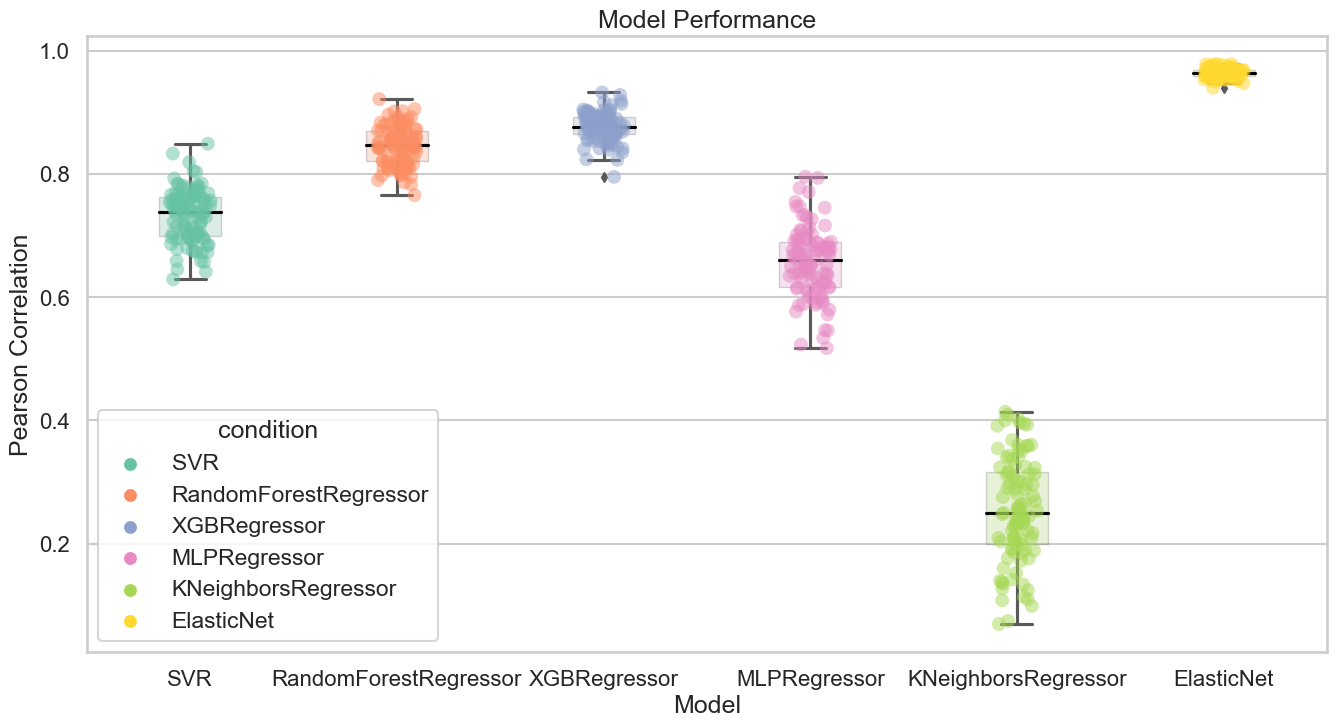

In [27]:
from Visualisation import plot_box_plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

fig, ax = plt.subplots(figsize=(16, 8))
plot_box_plot(df_all, 'condition', 'model_performance', 'Model Performance', 'Model'
              ,'Pearson Correlation', ax=ax, tick_fontsize=16)


In [28]:
# check the best model for each model category 
best_models = df_all.groupby('condition')['model_performance'].idxmax()

In [29]:
best_models

condition
ElasticNet                1
KNeighborsRegressor      46
MLPRegressor             49
RandomForestRegressor     1
SVR                      20
XGBRegressor             85
Name: model_performance, dtype: int64

In [30]:
# for each best performing model, re-run the pipeline and plot model results
for model_used in all_models:
    powerkit.add_condition(f'{model_used}_best', False, pipeline_func, {'model_used': model_used, 'normalised': normalised}, eval_func_best, {'normalised': normalised})

    

In [31]:
df_list = []
for model_used in all_models:
    print(f'Running {model_used}...')
    best_rng = df_all.loc[best_models[model_used]]['rng'].values[0]
    print(best_rng, model_used)
    # run pipeline with best rng
    df = powerkit.run_selected_condition(f'{model_used}_best', [best_rng], 1, True)
    df_list.append(df)

Running SVR...
20 SVR


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


Running RandomForestRegressor...
1 RandomForestRegressor


100%|██████████| 1/1 [00:37<00:00, 37.10s/it]


Running XGBRegressor...
85 XGBRegressor


100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


Running MLPRegressor...
49 MLPRegressor


100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


Running KNeighborsRegressor...
46 KNeighborsRegressor


100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Running ElasticNet...
1 ElasticNet


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


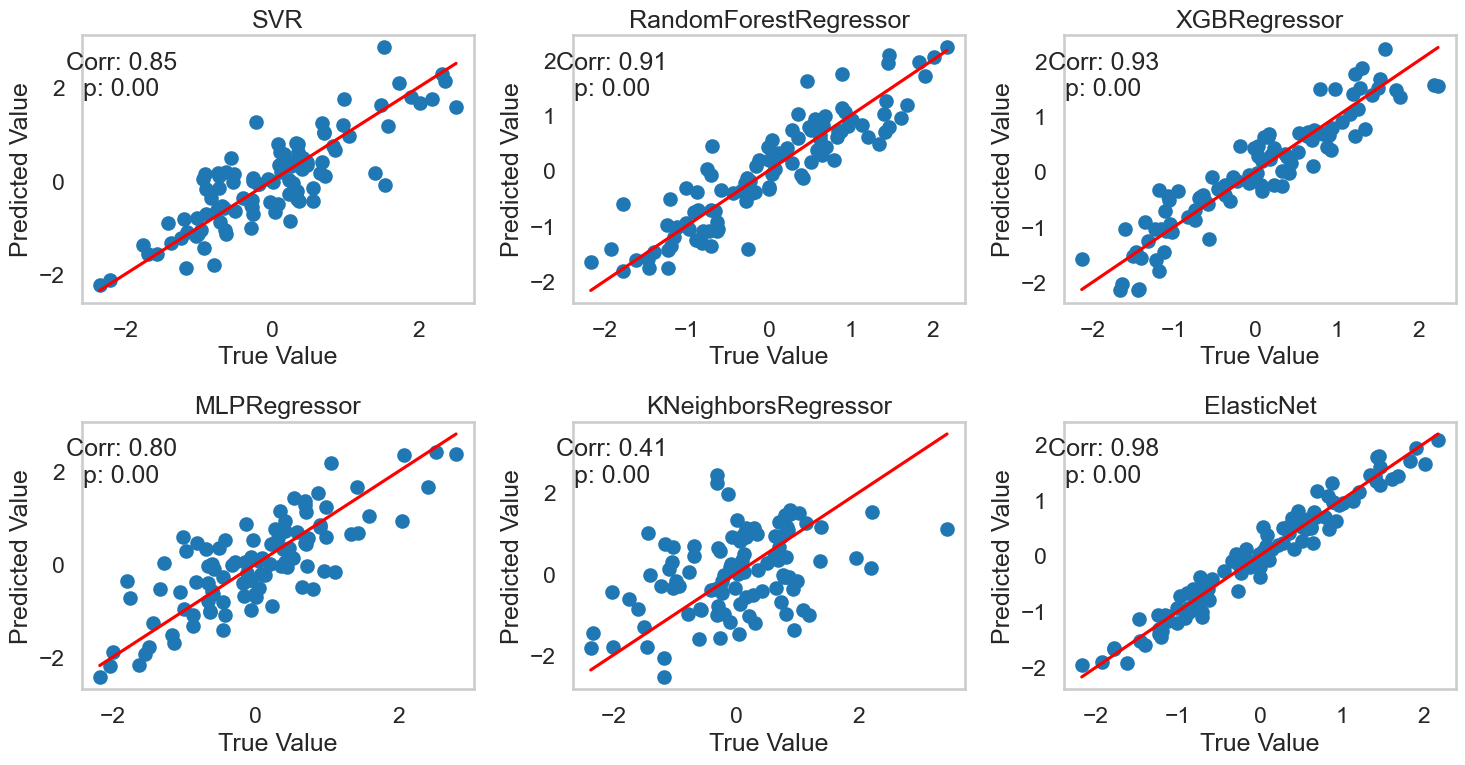

In [32]:
import math

plot_cols = 3
plot_rows = math.ceil(len(df_list)/plot_cols)
plt.subplots(plot_rows, plot_cols, figsize=(5*plot_cols, 4*plot_rows))

normalise = True

for i, df in enumerate(df_list):
    plt.subplot(plot_rows, plot_cols, i+1)
    # get y_test and y_pred
    y_test = df['y_test'].values[0]
    y_pred = df['y_pred'].values[0]
    model_used = df['condition'].values[0].split('_')[0]
    if normalise:
        y_test = (y_test - y_test.mean()) / y_test.std()
        y_pred = (y_pred - y_pred.mean()) / y_pred.std()
    # plot y_test vs y_pred
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title(f'{model_used}')
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    plt.text(0.1, 0.9, f'Corr: {corr:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'p: {p_vals:.2f}', ha='center', va='center', transform=plt.gca().transAxes)
    # plot y=x line
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.grid()


plt.tight_layout()
plt.show()

In [33]:
df_all

,rng,condition,model_performance,p_vals
0,0,SVR,0.702744,3.662809e-16
1,1,SVR,0.784337,4.846148e-22
2,2,SVR,0.757370,7.644572e-20
3,3,SVR,0.713433,8.153465e-17
4,4,SVR,0.686209,3.296674e-15
...,...,...,...,...
95,95,ElasticNet,0.961015,1.614064e-56
96,96,ElasticNet,0.966596,9.504258e-60
97,97,ElasticNet,0.965364,5.444938e-59
98,98,ElasticNet,0.969187,1.934893e-61


## Positive Control (CCLE Only)

In [34]:
powerkit = Powerkit(new_feature_data, new_label_data)

In [35]:
for model_used in all_models:
    powerkit.add_condition(model_used, True, pipeline_func, {'model_used': model_used, 'normalised': normalised}, eval_func, {'normalised': normalised})

In [36]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_ccle.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Positive Control 2 (Dynamic Features Only)

In [37]:
powerkit = Powerkit(dynamic_feature_data, dynamic_label_data)

In [38]:
for model_used in all_models:
    pipeline_args = {'model_used': model_used, 'normalised': normalised}
    eval_args = {'save_model': save_model, 'normalised': normalised}
    powerkit.add_condition(model_used, True, pipeline_func, pipeline_args, eval_func, eval_args)

In [39]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_control_dynamic.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Combined (CCLE + Dyn)

In [40]:
powerkit = Powerkit(combined_feature_data, combined_label_data)

In [41]:
for model_used in all_models:
    pipeline_args = {'model_used': model_used, 'normalised': normalised}
    eval_args = {'save_model': save_model, 'normalised': normalised}
    powerkit.add_condition(model_used, True, pipeline_func, pipeline_args, eval_func, eval_args)

In [42]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_combined.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Transformed Gene Only

In [43]:
sub_exp_id = 'specie_genes'

In [44]:
powerkit = Powerkit(combined_feature_data, combined_label_data)

In [45]:

for model_used in all_models:
    pipeline_args = {'model_used': model_used, 'keep_features': transformed_gene_list, 'normalised': normalised}
    eval_args = {'save_model': save_model, 'normalised': normalised}
    powerkit.add_condition(model_used, True, pipeline_select_only, pipeline_args, eval_func, eval_args)

In [46]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_{sub_exp_id}.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Select Genes and Combine Dynamic Features

In [47]:
sub_exp_id = 'select_gene_dynamic'

In [48]:
powerkit = Powerkit(combined_feature_data, combined_label_data)

In [49]:

for model_used in all_models:
    pipeline_args = {'model_used': model_used, 'keep_features': dynamic_features}
    eval_args = {'save_model': save_model, 'normalised': normalised}
    powerkit.add_condition(model_used, True, pipeline_select_genes_only, pipeline_args, eval_func, eval_args)

In [50]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_{sub_exp_id}.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Transformed Genes and Dynamic Features

In [51]:
sub_exp_id = 'specie_genes_dynamic'

In [52]:
powerkit = Powerkit(combined_feature_data, combined_label_data)

In [53]:

for model_used in all_models:
    pipeline_args = {'model_used': model_used, 'keep_features': transformed_dynamic_features}
    eval_args = {'save_model': save_model, 'normalised': normalised}
    powerkit.add_condition(model_used, True, pipeline_select_only, pipeline_args, eval_func, eval_args)

In [54]:
for model_used in all_models:
    print(f'Running {model_used}...')
    df = powerkit.run_selected_condition(model_used, rngs, core_used, True)
    if save_data:
        print(f'Saved {model_used} to path')
        df.to_pickle(f'{file_save_path}{exp_id}_{model_used}_{sub_exp_id}.pkl')

Running SVR...


Saved SVR to path
Running RandomForestRegressor...
Saved RandomForestRegressor to path
Running XGBRegressor...
Saved XGBRegressor to path
Running MLPRegressor...
Saved MLPRegressor to path
Running KNeighborsRegressor...
Saved KNeighborsRegressor to path
Running ElasticNet...
Saved ElasticNet to path


## Visualise all results 

### Data Loading

In [22]:
exp_id = 'fgfr4_v4'
folder_name = "FGFR4-combined-model-training"
file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'
experiments = ['control_negative', 'control_positive', 'control_dynamic',
               'specie_genes', 'specie_genes_dynamic', 
               'control_ccle','select_gene_dynamic']

import pickle 


df_list_total = []
for exp in experiments:
    df_list = []
    for model_used in all_models:
        df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
        print(f'Loaded {model_used} for {exp}')
        df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)
    
total_df = pd.concat(df_list_total, axis=0)
total_df

Loaded SVR for control_negative
Loaded RandomForestRegressor for control_negative
Loaded XGBRegressor for control_negative
Loaded MLPRegressor for control_negative
Loaded KNeighborsRegressor for control_negative
Loaded ElasticNet for control_negative
Loaded SVR for control_positive
Loaded RandomForestRegressor for control_positive
Loaded XGBRegressor for control_positive
Loaded MLPRegressor for control_positive
Loaded KNeighborsRegressor for control_positive
Loaded ElasticNet for control_positive
Loaded SVR for control_dynamic
Loaded RandomForestRegressor for control_dynamic
Loaded XGBRegressor for control_dynamic
Loaded MLPRegressor for control_dynamic
Loaded KNeighborsRegressor for control_dynamic
Loaded ElasticNet for control_dynamic
Loaded SVR for specie_genes
Loaded RandomForestRegressor for specie_genes
Loaded XGBRegressor for specie_genes
Loaded MLPRegressor for specie_genes
Loaded KNeighborsRegressor for specie_genes
Loaded ElasticNet for specie_genes
Loaded SVR for specie_gene

,rng,condition,model_performance,p_vals,experiment,feature_importance,model
0,0,SVR,-0.055129,0.585906,control_negative,NaN,NaN
1,1,SVR,0.022244,0.826128,control_negative,NaN,NaN
2,2,SVR,-0.046308,0.647309,control_negative,NaN,NaN
3,3,SVR,-0.082188,0.416263,control_negative,NaN,NaN
4,4,SVR,0.035394,0.726641,control_negative,NaN,NaN
...,...,...,...,...,...,...,...
95,95,ElasticNet,0.417813,0.000435,select_gene_dynamic,"([pIGFR_auc, pIGFR_median, pIGFR_tfc, pIGFR_tm...",ElasticNet()
96,96,ElasticNet,0.250623,0.040795,select_gene_dynamic,"([pIGFR_auc, pIGFR_median, pIGFR_tfc, pIGFR_tm...",ElasticNet()
97,97,ElasticNet,0.407610,0.000618,select_gene_dynamic,"([pIGFR_auc, pIGFR_median, pIGFR_tfc, pIGFR_tm...",ElasticNet()
98,98,ElasticNet,0.379826,0.001523,select_gene_dynamic,"([pIGFR_auc, pIGFR_median, pIGFR_tfc, pIGFR_tm...",ElasticNet()


### Graphical Generation

6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
41.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
54.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
26.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
80.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


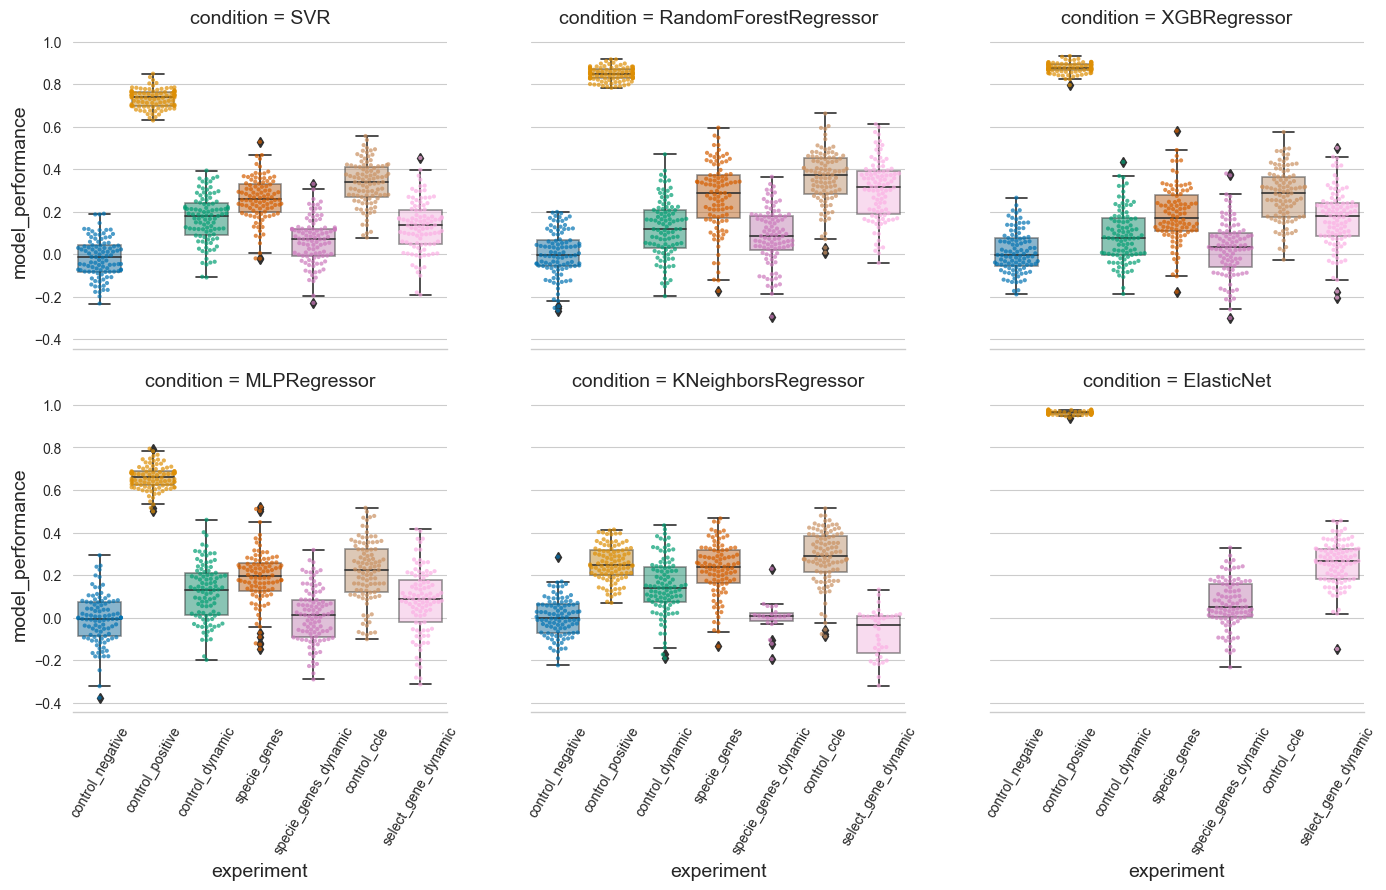

In [23]:
import seaborn as sns
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":14,"axes.labelsize":14, 'xtick.labelsize': 10, 'ytick.labelsize': 10}) 
sns.set_style("whitegrid")
sns.set_palette("colorblind")



g = sns.catplot(
    data=total_df, x="experiment", y="model_performance", col="condition",
    kind="box", height=4, aspect=1.2, sharey=True, sharex=True, col_wrap=3,
    boxprops=dict(alpha=.5),
)
g.set_xticklabels(rotation=60)
for ax in g.axes.flat:
    # ax.axhline(0, color='black', linestyle='--')
    condition_df = total_df[total_df['condition'] == ax.title.get_text().split('=')[1].strip(' ')]
    # print(ax.title.get_text().split('=')[1].strip(' '))
    sns.swarmplot(data=condition_df, x="experiment", y="model_performance", alpha=0.7, ax=ax, size=3)
    
g.despine(left=True)
plt.show()

In [ ]:
total_df

,rng,condition,model_performance,p_vals,experiment,feature_importance,model
0,0,SVR,-0.055129,0.585906,control_negative,NaN,NaN
1,1,SVR,0.022244,0.826128,control_negative,NaN,NaN
2,2,SVR,-0.046308,0.647309,control_negative,NaN,NaN
3,3,SVR,-0.082188,0.416263,control_negative,NaN,NaN
4,4,SVR,0.035394,0.726641,control_negative,NaN,NaN
...,...,...,...,...,...,...,...
95,95,ElasticNet,0.274392,0.035457,select_gene_dynamic,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...",ElasticNet()
96,96,ElasticNet,0.579212,0.000002,select_gene_dynamic,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...",ElasticNet()
97,97,ElasticNet,0.421444,0.000887,select_gene_dynamic,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...",ElasticNet()
98,98,ElasticNet,0.471720,0.000162,select_gene_dynamic,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...",ElasticNet()


### Tukey's test

In [58]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for condition, df in total_df.groupby('condition'):
    print(f'Condition: {condition}')
    print(pairwise_tukeyhsd(df['model_performance'], df['experiment']))

Condition: ElasticNet


           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
       group1              group2        meandiff p-adj lower upper reject
--------------------------------------------------------------------------
       control_ccle      control_dynamic  -0.2104   nan   nan   nan  False
       control_ccle     control_negative      nan   nan   nan   nan  False
       control_ccle     control_positive   0.3466   nan   nan   nan  False
       control_ccle  select_gene_dynamic  -0.1343   nan   nan   nan  False
       control_ccle         specie_genes  -0.1974   nan   nan   nan  False
       control_ccle specie_genes_dynamic  -0.6291   nan   nan   nan  False
    control_dynamic     control_negative      nan   nan   nan   nan  False
    control_dynamic     control_positive    0.557   nan   nan   nan  False
    control_dynamic  select_gene_dynamic   0.0762   nan   nan   nan  False
    control_dynamic         specie_genes    0.013   nan   nan   nan  False
    control_dynamic speci

### Contribution Analysis

In [59]:
for e in experiments:
    pass 

tree_df = total_df[total_df['condition'] == 'RandomForestRegressor']